# 🌳 Pemodelan Klasifikasi — Deep Dive Decision Tree (Pohon Keputusan)

### Jembatan Konseptual

Selamat datang di bagian **1.c** dari seri pemodelan kita. Setelah pada bagian sebelumnya kita menjelajahi model berbasis jarak seperti **KNN**, kini kita beralih ke paradigma yang sama sekali berbeda: **model berbasis aturan (rule-based)**. Kita akan melakukan analisis mendalam pada **Decision Tree (Pohon Keputusan)**.

### Filosofi Decision Tree: "Serangkaian Pertanyaan Cerdas"

Bayangkan Decision Tree seperti seorang detektif yang mengajukan serangkaian pertanyaan "ya/tidak" yang paling efisien untuk sampai pada sebuah kesimpulan. Model ini bekerja dengan cara memecah data secara rekursif menjadi subset-subset yang lebih kecil dan lebih murni.

* **Akar (Root Node):** Titik awal yang berisi seluruh dataset.
* **Cabang (Branch):** Mewakili sebuah aturan atau keputusan (misalnya, "apakah `petal_length` <= 2.45 cm?").
* **Daun (Leaf Node):** Titik akhir yang memberikan hasil klasifikasi (misalnya, "Spesies adalah setosa").

Keunggulan terbesarnya adalah **interpretabilitas**—kita bisa dengan mudah melihat alur "pemikiran" model. Namun, tantangan terbesarnya adalah kecenderungan untuk **overfitting**, di mana model menjadi terlalu kompleks dan menghafal data latihan.

Di notebook ini, kita akan membangun, memvisualisasikan, mengevaluasi, dan melakukan *pruning* (pemangkasan) pada model Decision Tree untuk mendapatkan model yang tidak hanya akurat, tetapi juga robust.

### Langkah 1: Setup Mandiri & Persiapan Data Lengkap

Seperti biasa, sel pertama ini akan menangani semua yang kita butuhkan: mengimpor pustaka, memuat data mentah, dan menerapkan seluruh alur pra-pemrosesan yang telah kita sepakati (standarisasi dan penghapusan outlier dengan LOF), hingga membagi data menjadi set pelatihan dan pengujian.

In [1]:
# =======================================================
# SETUP MANDIRI UNTUK PEMODELAN DECISION TREE
# =======================================================

# 1. Import Pustaka
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("Pustaka yang dibutuhkan telah diimpor.")

# 2. Memuat dan Membuat DataFrame Awal
iris = load_iris()
df_full = pd.DataFrame(data=iris.data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
df_full['species'] = [iris.target_names[i] for i in iris.target]
print("Dataset Iris mentah berhasil dibuat.")

# 3. Pra-Pemrosesan: Standarisasi & Penghapusan Outlier dengan LOF
print("\nMemulai pra-pemrosesan...")
# Penskalaan (diperlukan untuk LOF)
features_to_scale = df_full[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_to_scale)

# Deteksi Outlier dengan LOF
lof = LocalOutlierFactor(n_neighbors=20)
outlier_labels = lof.fit_predict(features_scaled)
df_full['outlier_lof'] = outlier_labels

# Menghapus Outlier
df_processed = df_full[df_full['outlier_lof'] == 1].copy()
df_processed = df_processed.drop(columns=['outlier_lof'])
print(f"Penghapusan outlier selesai. Sisa data: {df_processed.shape[0]} baris.")

# 4. Pra-Pemrosesan: Label Encoding pada Target
encoder = LabelEncoder()
df_processed['species_encoded'] = encoder.fit_transform(df_processed['species'])
print("Label encoding untuk variabel target selesai.")

# 5. Memisahkan Fitur (X) dan Target (y)
# Catatan: Decision Tree tidak wajib menggunakan data yang diskalakan, jadi kita bisa gunakan data asli yang sudah bersih.
X = df_processed[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
y = df_processed['species_encoded']

# 6. Pembagian Data (Train-Test Split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("\nPembagian data menjadi set latih dan uji selesai.")
print(f"Ukuran X_train: {X_train.shape}")
print(f"Ukuran X_test: {X_test.shape}")

Pustaka yang dibutuhkan telah diimpor.
Dataset Iris mentah berhasil dibuat.

Memulai pra-pemrosesan...
Penghapusan outlier selesai. Sisa data: 144 baris.
Label encoding untuk variabel target selesai.

Pembagian data menjadi set latih dan uji selesai.
Ukuran X_train: (100, 4)
Ukuran X_test: (44, 4)


### Langkah 2: Membangun & Visualisasi Model Decision Tree Dasar

Pertama, kita akan membangun model tanpa batasan apapun pada pertumbuhannya. Ini akan menunjukkan kepada kita bagaimana pohon keputusan secara alami mencoba untuk menjadi "sempurna" pada data latihan, yang seringkali mengarah ke overfitting.

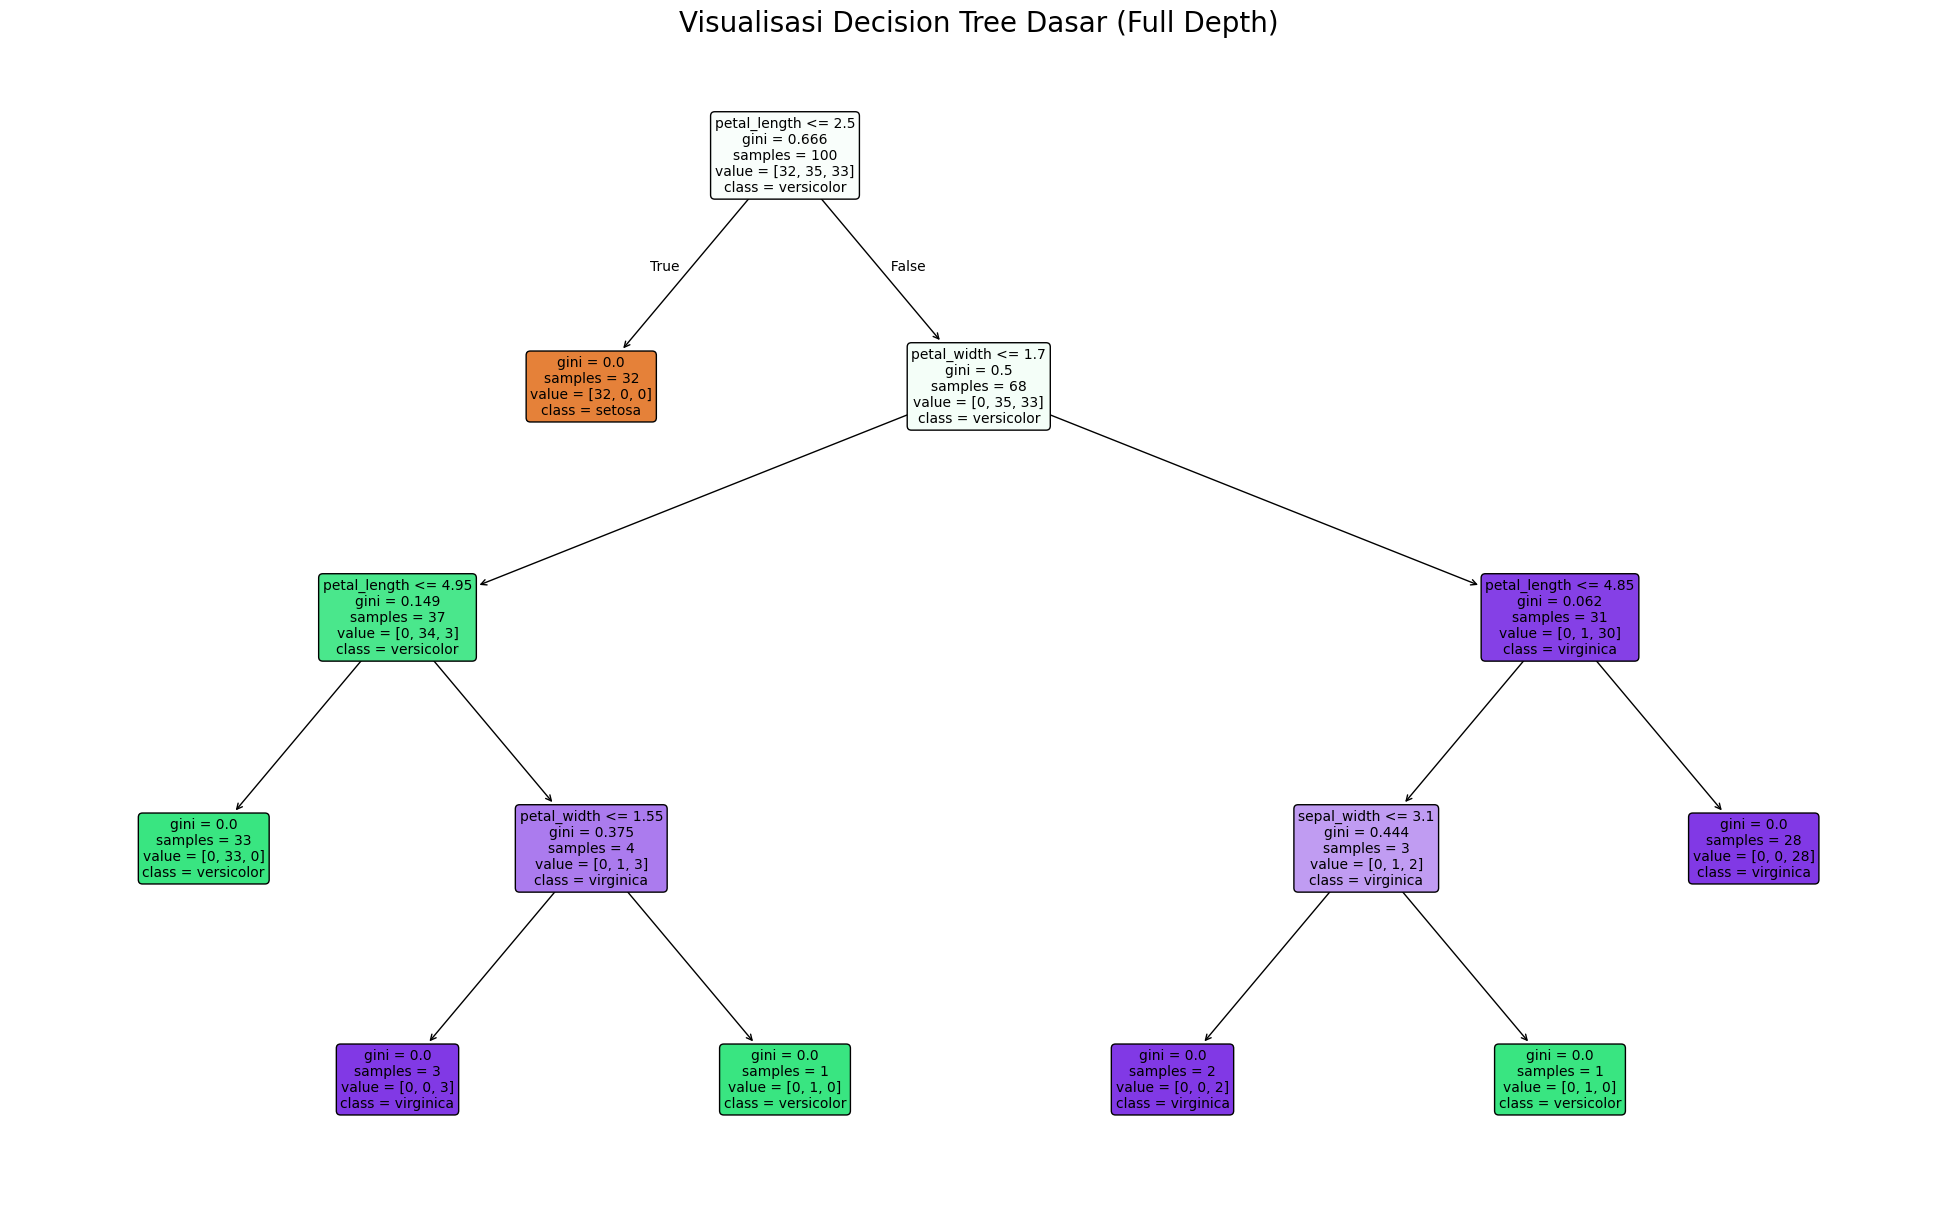

In [2]:
# Inisialisasi dan latih model Decision Tree dasar
tree_base = DecisionTreeClassifier(random_state=42)
tree_base.fit(X_train, y_train)

# Visualisasi pohon yang kompleks
plt.figure(figsize=(25, 15))
plot_tree(tree_base, 
          feature_names=X.columns,
          class_names=encoder.classes_,
          filled=True, 
          rounded=True,
          fontsize=10)
plt.title("Visualisasi Decision Tree Dasar (Full Depth)", fontsize=20)
plt.show()

**Analisis Visual:**
Seperti yang terlihat, pohon keputusan ini tumbuh sangat dalam dan memiliki banyak cabang. Ia menciptakan aturan-aturan yang sangat spesifik hanya untuk memastikan setiap sampel di data latihan terklasifikasi dengan benar. Ini adalah tanda visual yang jelas dari **overfitting**. Model seperti ini mungkin akan bekerja buruk pada data baru yang belum pernah ia lihat.

### Langkah 3: Pruning — Mencegah Overfitting dengan `max_depth`

Untuk mengatasi overfitting, kita perlu melakukan **pruning** (pemangkasan). Cara paling sederhana adalah *pre-pruning*, yaitu dengan menghentikan pertumbuhan pohon lebih awal. Kita akan menggunakan hyperparameter `max_depth` untuk membatasi kedalaman pohon.

Membatasi kedalaman akan memaksa model untuk hanya mempelajari pola-pola yang paling penting dan umum, sehingga meningkatkan kemampuannya untuk generalisasi ke data baru.

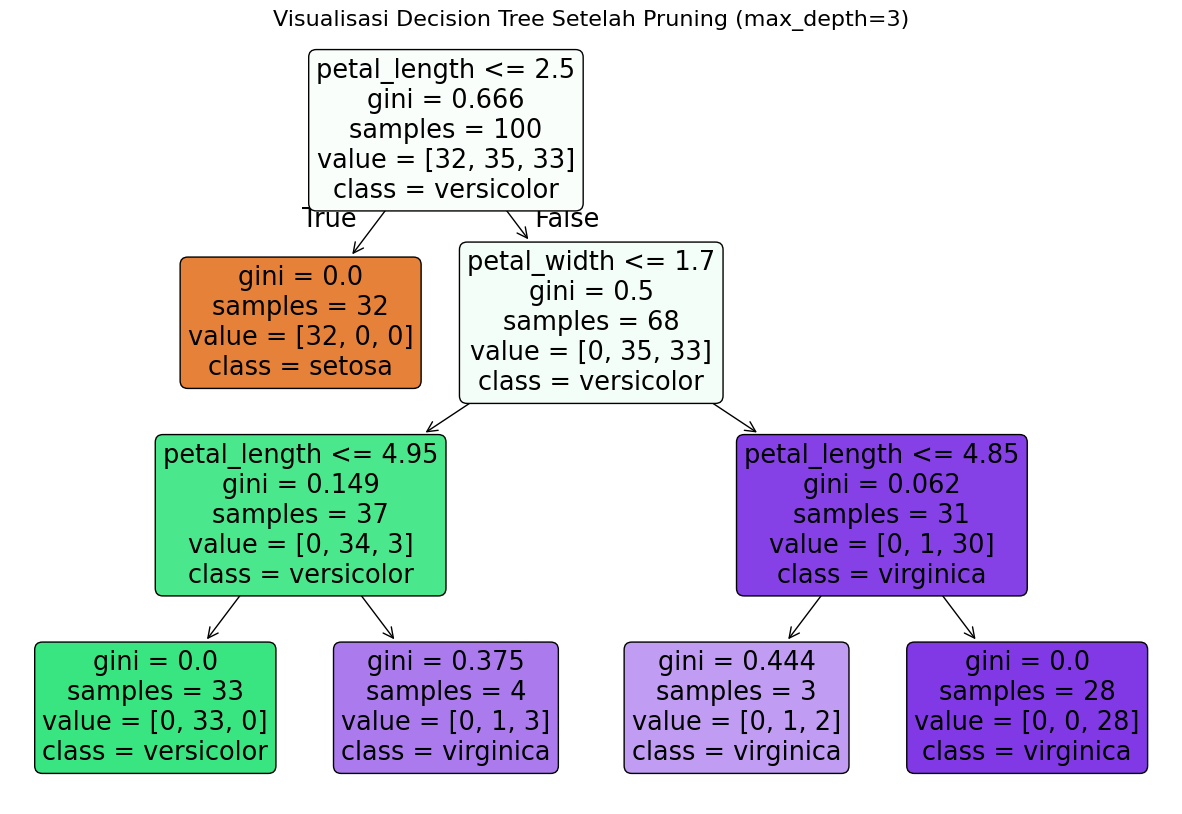

In [3]:
# Inisialisasi dan latih model Decision Tree yang sudah di-pruning
tree_pruned = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_pruned.fit(X_train, y_train)

# Visualisasi pohon yang lebih sederhana
plt.figure(figsize=(15, 10))
plot_tree(tree_pruned, 
          feature_names=X.columns,
          class_names=encoder.classes_,
          filled=True, 
          rounded=True)
plt.title("Visualisasi Decision Tree Setelah Pruning (max_depth=3)", fontsize=16)
plt.show()

**Analisis Visual (Pruned):**
Jauh lebih baik! Pohon ini sangat mudah dibaca dan diinterpretasikan. Kita bisa mengikuti alur keputusannya dari akar hingga daun dengan mudah. Contohnya, aturan pertama di akar adalah `petal_width <= 0.8`. Jika `True`, maka dipastikan itu adalah `setosa`.

Sekarang, mari kita evaluasi performa model yang lebih sederhana ini pada data uji.

--- Laporan Klasifikasi Model Decision Tree (Pruned, max_depth=3) ---
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      0.93      0.97        15
   virginica       0.93      1.00      0.97        14

    accuracy                           0.98        44
   macro avg       0.98      0.98      0.98        44
weighted avg       0.98      0.98      0.98        44



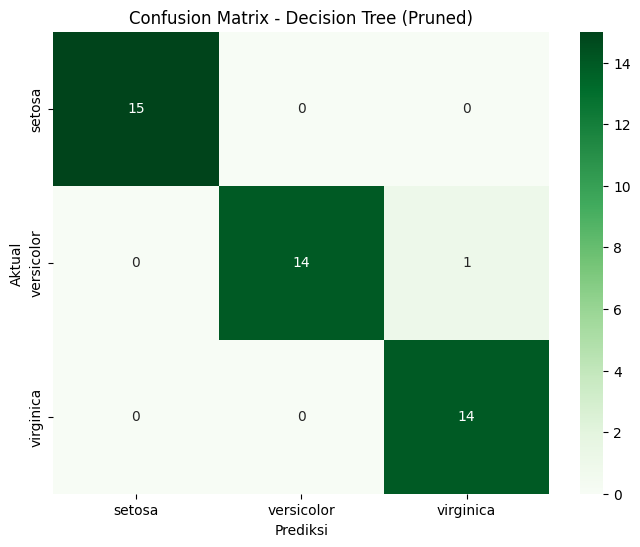

In [4]:
# Lakukan prediksi menggunakan model yang sudah di-pruning
y_pred_pruned = tree_pruned.predict(X_test)

# Evaluasi model
print("--- Laporan Klasifikasi Model Decision Tree (Pruned, max_depth=3) ---")
print(classification_report(y_test, y_pred_pruned, target_names=encoder.classes_))

# Visualisasi Confusion Matrix
cm_pruned = confusion_matrix(y_test, y_pred_pruned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_pruned, annot=True, fmt='d', cmap='Greens',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix - Decision Tree (Pruned)')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

Performa model yang sudah di-pruning tetap sangat tinggi, menunjukkan bahwa aturan-aturan kompleks dari pohon yang pertama tidak diperlukan dan kemungkinan besar hanya menangkap noise.

### Langkah 4: Analisis Pentingnya Fitur (Feature Importance)

Salah satu keunggulan besar dari Decision Tree adalah kemampuannya untuk memberi tahu kita fitur mana yang paling berpengaruh dalam membuat keputusan. Ini diukur berdasarkan seberapa besar sebuah fitur mampu mengurangi *impurity* (ketidakmurnian) pada setiap pemisahan.

--- Tingkat Kepentingan Fitur ---


,Feature,Importance
2,petal_length,0.584214
3,petal_width,0.415786
1,sepal_width,0.000000
0,sepal_length,0.000000


/tmp/ipykernel_17742/190554365.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


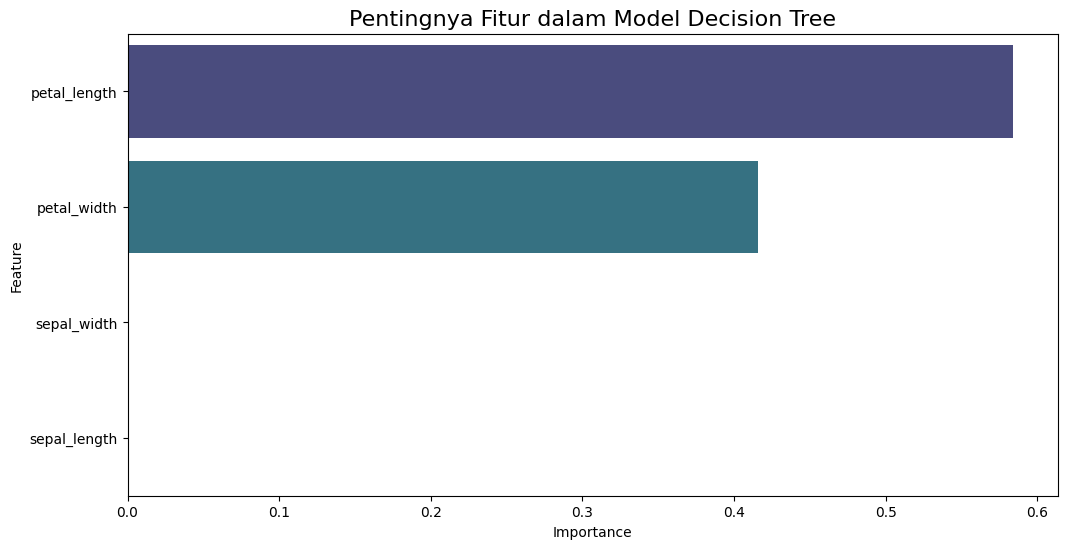

In [5]:
# Mendapatkan skor pentingnya fitur dari model yang sudah di-pruning
importances = tree_pruned.feature_importances_

# Membuat DataFrame untuk visualisasi
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("--- Tingkat Kepentingan Fitur ---")
display(feature_importance_df)

# Visualisasi Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Pentingnya Fitur dalam Model Decision Tree', fontsize=16)
plt.show()

**Analisis Kepentingan Fitur:**
Hasil ini sangat konsisten dengan analisis kita di tahap *Data Understanding*. **`petal_width`** dan **`petal_length`** adalah dua fitur yang paling dominan dalam menentukan spesies bunga Iris. Fitur-fitur `sepal` memiliki kontribusi yang jauh lebih kecil.

### Penutup dan Jembatan Konseptual

Dalam notebook ini, kita telah mengupas tuntas model **Decision Tree**. Kita belajar tentang risiko overfitting dan cara mengatasinya dengan *pruning*, cara memvisualisasikan aturan model, dan cara mengekstrak informasi tentang fitur mana yang paling penting.

Kita telah menyelesaikan eksplorasi tiga model **klasifikasi (supervised learning)**: Naive Bayes, KNN, dan Decision Tree. Masing-masing memiliki cara kerja dan keunggulannya sendiri.

#### Jembatan ke Seri Selanjutnya
Pada **seri selanjutnya (2. Clustering)**, kita akan beralih dari *supervised learning* ke *unsupervised learning*. Kita tidak akan lagi memprediksi label yang sudah ada ('species'), melainkan mencoba menemukan struktur atau kelompok alami dalam data tanpa menggunakan label tersebut. Kita akan memulainya dengan algoritma clustering paling populer: **K-Means**.